In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
d = loadmat('data.mat')['data']
d.shape

(2500, 3)

In [4]:
X = d[:, :2]
U = d[:, 2]
X.shape, U.shape

((2500, 2), (2500,))

In [5]:
n_neurons = 10
inputs = tf.keras.Input(shape=(2))
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(inputs)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(n_neurons, activation='tanh')(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110   

In [6]:
lambda_1 = tf.Variable(0.0, trainable=True, dtype='float32')
lambda_2 = tf.Variable(0.0, trainable=True, dtype='float32')
lambda_1, lambda_2

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>)

In [7]:
class NeuralNet(tf.keras.Model):
    def __init__(self, model, lambda_1, lambda_2, **kwargs):
        super(NeuralNet, self).__init__(**kwargs)
        self.model = model
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, X):
        U = self.model(X)
        return U
    
    def train_step(self, data):
        X, y = data
        y = tf.reshape(y, shape=(y.shape[0], 1))
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(X)
            with tf.GradientTape() as tape2:
                tape2.watch(X)
                U = self.model(X)
                Uxt = tape2.gradient(U, X)
                Ux = Uxt[:, 0:1]
                Ut = Uxt[:, 1:2]
            Uxx = tape1.gradient(Ux, X)[:, 0:1]
            f = Ut + self.lambda_1*tf.multiply(U, Ux) - self.lambda_2*Uxx
            loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(U, y)))
            loss += tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(f, 0.0)))
        train_vars = self.model.trainable_variables
        train_vars.append(self.lambda_1)
        train_vars.append(self.lambda_2)
        grads = tape1.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [8]:
nn = NeuralNet(model, lambda_1, lambda_2)

In [9]:
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10, verbose=1, factor=0.001, min_lr=0.00001)

In [ ]:
history = nn.fit(X, U, epochs=20000, batch_size=100, callbacks=[learning_rate_reduction])

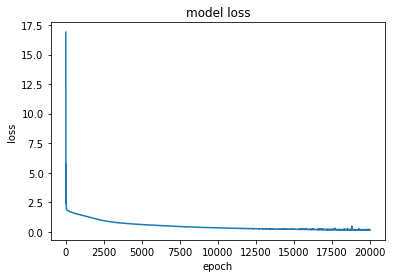

In [11]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [12]:
lambda_1

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.88790715>

In [13]:
lambda_2

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.004732143>